I computed realizations of multiple HODs for a few statistics in the darksky boxes. This notebook is gonna combine them into a jackknife covmat. It'll also add some estimate of the shape noise contribution. 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [2]:
import numpy as np
from glob import glob
from os import path

In [3]:
#shape_noise_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/shape_noise.npy')
shape_noise_covmat = np.load('./Hankel_transform/shape_noise.npy')

In [4]:
print np.sqrt(np.diag(shape_noise_covmat))

[1.98730768 1.67045335 1.44337859 1.15723198 0.90723776 0.62954749
 0.48874957 0.35539023 0.26374912 0.20003547 0.15066876 0.1153114
 0.08994637 0.07121648 0.05812927 0.04855829 0.04128168 0.03533467]


In [5]:
output_dir = '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat_v2/'

In [6]:
outputs = sorted(glob(path.join(output_dir, 'wp_ds_cic_darksky_obs_???_v2.npy')))
print len(outputs)

512


In [7]:
N = len(outputs) # Should be 512, but a few may not have finished. Should make sure that those get reestarted, but likely not super important
all_outputs = np.zeros((N, 5,  2*18 + 14)) # num bins and num HODs 

In [8]:
2*18+14

50

In [9]:
for i,output_file in enumerate(outputs):
    output = np.load(output_file)

    all_outputs[i] = output#.mean(axis = 0)

In [10]:
all_outputs.shape

(512, 5, 50)

In [11]:
rp_bins = np.logspace(-1.0, 1.6, 19)
cic_bins = np.round(np.r_[np.linspace(1, 9, 8), np.round(np.logspace(1,2, 7))] )

In [12]:
cic_bins

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  15.,  22.,
        32.,  46.,  68., 100.])

In [13]:
rp_points = (rp_bins[1:]+rp_bins[:-1])/2.0
cic_points = (cic_bins[1:]+cic_bins[:-1])/2.0

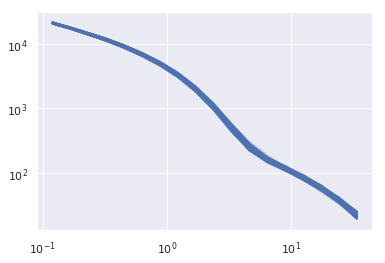

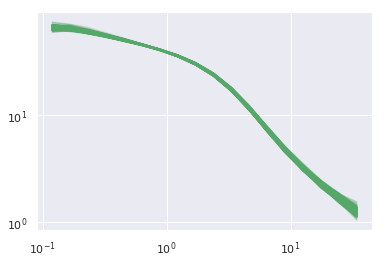

In [14]:
hod_idx = 4
plt.plot(rp_points, (all_outputs[:,hod_idx, :18]).T, alpha = 0.3, color = 'b')
plt.loglog();
plt.show();
plt.plot(rp_points, (all_outputs[:,hod_idx, 18:36]).T, alpha = 0.3, color = 'g')
plt.loglog();
plt.show();
#plt.plot(cic_points, all_outputs[idx, 36:])
#plt.loglog();
#plt.show();

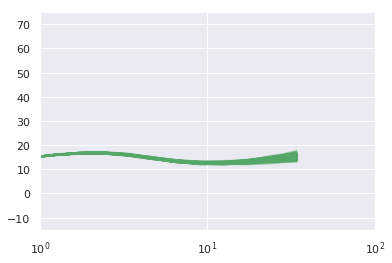

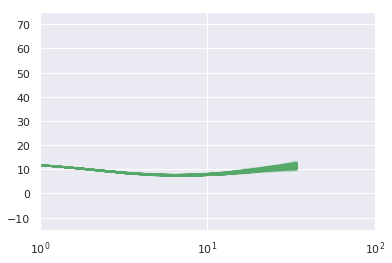

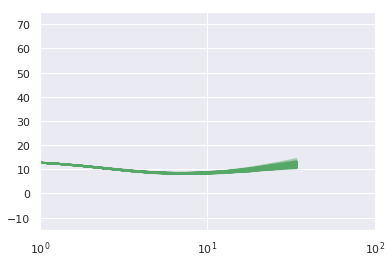

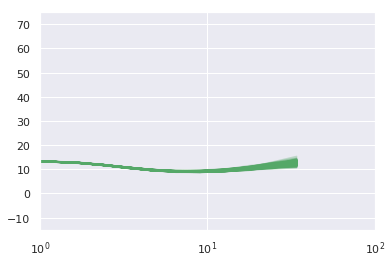

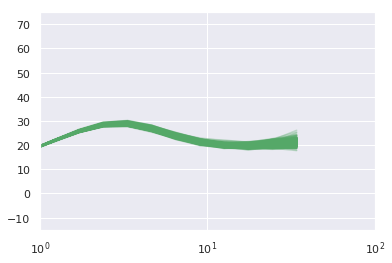

In [15]:
for hod_idx in xrange(5):
    #plt.plot(rp_points, (rp_points*all_outputs[:,hod_idx, :18]).T, alpha = 0.3, color = 'b')
    #plt.xscale('log');
    #plt.show();
    plt.plot(rp_points, (rp_points*all_outputs[:,hod_idx, 18:36]).T*(0.704**2), alpha = 0.3, color = 'g')
    plt.xscale('log');
    plt.ylim([-15, 75])
    plt.xlim([1, 100])
    plt.show();
    #plt.plot(cic_points, all_outputs[idx, 36:])
    #plt.loglog();
    #plt.show();

In [16]:
mean = all_outputs.mean(axis = 0)

In [17]:
R =(all_outputs - mean)

cov = np.zeros((R.shape[2], R.shape[2]))
for i in xrange(R.shape[1]):
    cov+= R[:,i].T.dot(R[:,i])#/(N-1)
    
cov/=R.shape[1]*(N-1)

In [18]:
cov.shape

(50, 50)

In [19]:
np.min(cov)

-60.12955951942387

In [20]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

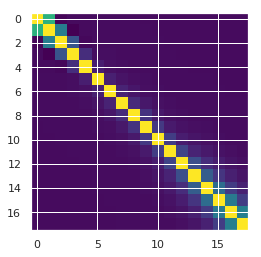

In [21]:
plt.imshow(cov_to_corr(shape_noise_covmat), cmap = 'viridis')

In [22]:
print(cov_to_corr(shape_noise_covmat))[:5, :5]

[[ 1.00000000e+00  6.32399758e-01 -1.95631648e-02 -3.35533582e-03
  -4.00849590e-04]
 [ 6.32399758e-01  1.00000000e+00  4.05267340e-01 -3.21651899e-02
  -5.48728371e-04]
 [-1.95631648e-02  4.05267340e-01  1.00000000e+00  2.36628626e-01
  -1.10439417e-02]
 [-3.35533582e-03 -3.21651899e-02  2.36628626e-01  1.00000000e+00
   1.02207173e-01]
 [-4.00849590e-04 -5.48728371e-04 -1.10439417e-02  1.02207173e-01
   1.00000000e+00]]


In [23]:
from copy import deepcopy

In [24]:
full_cov = deepcopy(cov)

full_cov[18:36][:, 18:36] = full_cov[18:36][:, 18:36]+ shape_noise_covmat

In [25]:
corr = cov_to_corr(cov)
full_corr = cov_to_corr(full_cov)

In [26]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

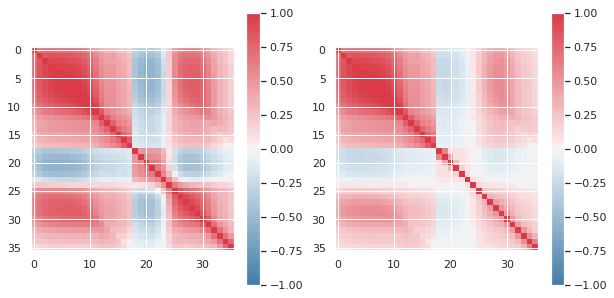

In [27]:
fig = plt.figure(figsize = (10, 5))
plt.subplot(121)
im = plt.imshow(corr[:36][:, :36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(122)
im = plt.imshow(full_corr[:36][:, :36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

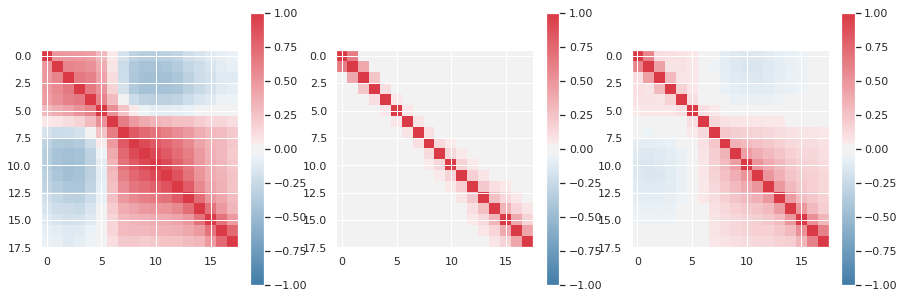

In [28]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
im = plt.imshow(corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(132)
im = plt.imshow(cov_to_corr(shape_noise_covmat), cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(133)
im = plt.imshow(full_corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

In [29]:
np.sqrt(np.diag(full_corr)[18:36])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

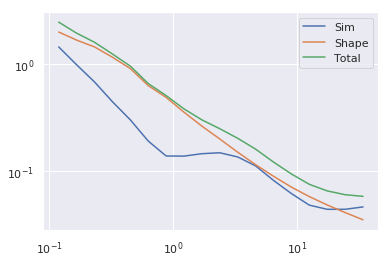

In [30]:
plt.plot(rp_points, np.sqrt(np.diag(cov)[18:36]), label = 'Sim')
plt.plot(rp_points,np.sqrt(np.diag(shape_noise_covmat)), label = 'Shape')

plt.plot(rp_points,np.sqrt(np.diag(full_cov)[18:36]), label = 'Total')
#plt.xscale('log')
plt.loglog();
plt.legend(loc = 'best')

In [31]:
print full_corr[30:30+5][:, 30:30+5]

[[1.         0.48140093 0.30150919 0.21913221 0.18472439]
 [0.48140093 1.         0.4578195  0.28777316 0.2224667 ]
 [0.30150919 0.4578195  1.         0.4885601  0.2981793 ]
 [0.21913221 0.28777316 0.4885601  1.         0.52962685]
 [0.18472439 0.2224667  0.2981793  0.52962685 1.        ]]


In [32]:
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_ds_full_covmat.npy', full_cov[:36][:, :36])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_full_covmat.npy', full_cov[:18][:, :18])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/ds_full_covmat.npy', full_cov[18:36][:, 18:36])

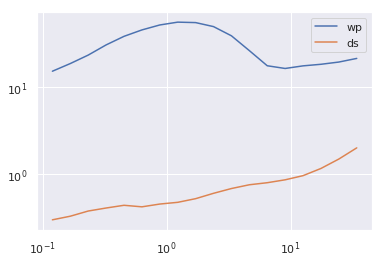

In [33]:
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[:18, :18]) ), label = 'wp')
#plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat) ), label = 'Shape')
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[18:36, 18:36]) ), label = 'ds')

plt.loglog()
plt.legend(loc='best')

In [34]:
print  np.sqrt(np.diag(full_cov[18:36, 18:36]) )

[2.45626592 1.93894725 1.59572687 1.2400769  0.95614317 0.65804861
 0.50813948 0.38146886 0.30148622 0.24937707 0.20306833 0.16097192
 0.12190367 0.09443919 0.07564087 0.06570484 0.06054742 0.05847955]


In [35]:
#emu covs
emu_cov_fnames = ['/home/users/swmclau2/Git/pearce/bin/optimization/wp_hod_emu_cov.npy',
                  '/home/users/swmclau2/Git/pearce/bin/optimization/ds_hod_emu_cov.npy']

In [36]:
emu_cov = np.zeros_like(full_cov[:36][:, :36])

for i, fname in enumerate(emu_cov_fnames):
    
    emu_cov[i*18:(i+1)*18][:, i*18:(i+1)*18] = np.load(fname)

In [37]:
emu_corr = cov_to_corr(emu_cov)

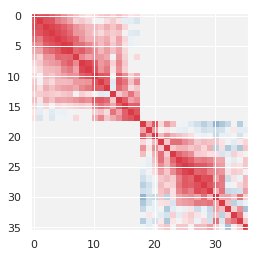

In [38]:
plt.imshow(emu_corr, cmap = cmap, vmin = -1)

In [39]:
full_emu_cov = full_cov[:36][:, :36] + emu_cov

In [40]:
full_emu_corr = cov_to_corr(full_emu_cov)

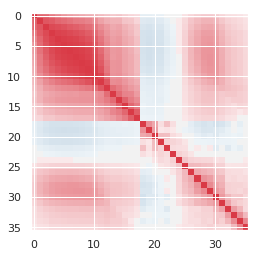

In [41]:
plt.imshow(full_emu_corr, cmap = cmap, vmin = -1)

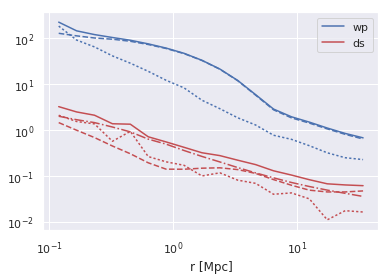

In [42]:
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[:18, :18]) ), label = 'wp', color = 'b')
plt.plot(rp_points, np.sqrt(np.diag(cov[:18, :18]) ), color = 'b', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[:18, :18]) ), color = 'b', ls = ':')


#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'ds', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'r', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'r',  ls = '-.')

#plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

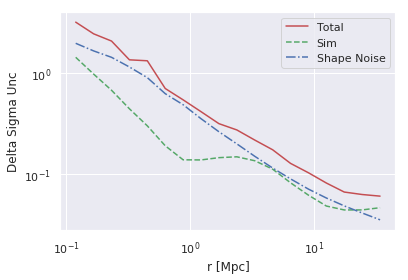

In [43]:
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'Total', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'g', label = 'Sim', ls = '--')
#plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'b', label = 'Shape Noise',ls = '-.')

plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

In [44]:
0.7**2

0.48999999999999994